## IFT 3700 - 21 Décembre 2018 - Travail 2
### David Ogaus(1004183), Jonathan Caspar (20059041), Tommy Côté(1056362) et Xiuli Zhang (20039439)
------------

## Question 1
---------
Cette question est une compétition entre les équipes et sera évaluée en fonction de la précision du classifieur produit par chaque équipe. Les données sont contenues dans le fichier PATCH.amat et il s’agit de 50000 images (28 x 28) en noir et blanc codées en binaire. Les images sont abstraites et appartiennent à deux catégories distinctes. Le fichier contient une image par ligne et chaque ligne commence par 784=28 * 28 bits associés à la couleur des pixels et suivi d’un bit représentant la classe. Le codage du fichier est lisible, mais nécessite un prétraitement pour être utilisé. L’équipe doit produire un classifieur qui sera mis en production et évalué sur des données fraîches non disponibles à l’équipe (mais qui ont exactement la même distribution). Les équipes avec une solution minimalement raisonnable seront classées en ordre de précision et le rang sera transformé en note variant de 10 à 25 sur 25.

![DataShape](datashape.jpg)

### Importation du fichier PATCH.amat

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import svm
%matplotlib inline

In [2]:
file = open("PATCH.amat")
rawData = list(file) # contient une liste de 50.000 vecteurs

In [3]:
regex = re.compile("\s*(0|1)\.") # expression régulière qui extrait chaque chiffre (0 ou 1) situé avant un point
data, label = [], []

for vector in rawData :
    parsedVector = re.findall(regex, vector)
    intVector = [int(pixel.strip()) for pixel in parsedVector]
    label.append(intVector.pop(784)) # on retire le dernier bit correspondant à la classe du vecteur et on l'ajoute dans label
    data.append(intVector) # on ajoute le vecteur de pixels (auquel on a retiré le dernier bit) dans "data"

En convertissant nos vecteurs en matrice 28 x 28, on peut visualiser quelques vecteurs de **classe 0** et de **classe 1** :

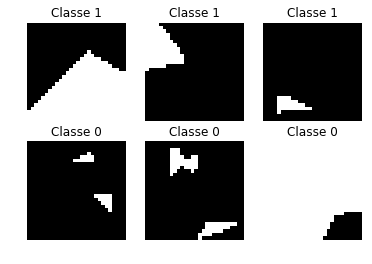

In [4]:
# Extraction d'échantillons
dataSample = [data[i] for i in range(403,406)] + [data[i] for i in range(40003,40006)]
labelSample = [label[i] for i in range(403,406)] + [label[i] for i in range(40003,40006)]

# Affichage de chaque échantillon et leurs classes respectives
for i, vector in enumerate(dataSample):
    ax = plt.subplot(2, 3, i+1)
    plt.axis('off')
    ax.set_title("Classe " + str(labelSample[i]))
    matrix = np.reshape(vector, (28,28))
    plt.imshow(matrix, cmap='gray')

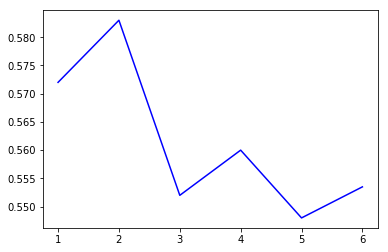

In [37]:
from sklearn import metrics
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data[20000:30000], label[20000:30000], test_size=0.2) # 70% training and 30% test

score = []
for k in range(1,7):
    KNN = KNeighborsClassifier(n_neighbors=k)
    KNN.fit(X_train, y_train)
    y_pred = KNN.predict(X_test)
    score.append(metrics.accuracy_score(y_test, y_pred))
 
plt.plot(np.arange(1,7), score, color='blue')

Le score de classification de KNN est **maximisé** pour $k=2$.

Testons donc ce même classifieur sur l'ensemble des données avec un **hyperparamètre** $k=2$.

In [38]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(data, label, test_size=0.3) # 70% training and 30% test
KNN = KNeighborsClassifier(n_neighbors=2)
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
print("Score de KNN(k=2) :", metrics.accuracy_score(y_test, y_pred))

Score de KNN(k=2) : 0.6034666666666667


## Question 2
---------
Imaginez qu’on vous donne un fichier contenant des données de nature astronomique. Il s’agit de données concernant 6500 milliards d’étoiles. Les données (dépassant la centaine de téraoctets) sont réparties sur **300 serveurs** avec un accès rapide au disque et une bonne capacité de calcul. La connexion entre les serveurs est rapide, mais pas exceptionnelle.

Les données pour chaque étoile comporte, la position dans l’espace (x,y,z), la luminosité apparente de l’étoile et sa catégorie (10 catégories possibles). Aussi, pour chaque étoile une liste de ses caractéristiques physiques représentées par 22 nombres réels est incluse.

Proposez une approche distribuée qui permet de répondre aux questions suivantes et expliquez en détail toute la démarche permettant leur résolution.

1. _**Trouvez les 1000 paires d’étoiles jumelles les plus proches (distance euclidienne de la position).**_
    
    ...
    
2. _**Comptez combien d'étoiles il y a dans chaque catégorie.**_

    On peut se servir à nouveau de **MapReduce** :

    1. __Etape "Mapping"__ : on demande au 300 serveurs d'itérer sur chaque étoile qu'ils contiennent, à l'issue de ce parcours, ils doivent produire une liste de paires **<clé, valeur>** telles que :
        * la **clé** correspond à la valeur de la catégorie de chaque étoile (entre 1 et 10)
        * la **valeur** correspond au nombre de catégories trouvées pour chaque étoile (i.e. toujours 1 dans ce cas)
    
    2. __Etape "Reduce"__ : chaque serveur doit réduire leurs listes résultantes en regroupant les paires ayant la même clé (chaque regroupement incrémente la valeur de la paire de 1) : mène à la production d'une liste de 1 à 10 paires (puisqu'une des 10 catégories peut ne pas apparaitre sur un serveur en particulier) correspondant à chaque catégorie d'étoile et le nombre d'étoiles y appartenant pour **CHAQUE** serveur.
    
    3. __Etape "Regroupement"__ : les 300 listes de 1 à 10 paires sont envoyées à un **serveur central** qui s'occupe de mettre bout à bout les listes (temps pratiquement linéaire)
    
    4. __Etape "Reduce"__ : le serveur central doit réduire les listes comme dans l'étape 2.
    
    A la fin de ce traitement, la liste résultante est une liste contenant 10 paires correspondants à chaque catégorie d'étoiles et le nombre d'étoiles y appartenant en ayant pris en compte **TOUTES** les données contenues par les 300 serveurs.


3. _**Produisez un classifieur qui, étant donné le vecteur de caractéristiques (22 nombres réels), prédit la catégorie de l’étoile.**_

    1. __Etape "Mapping"__ : on demande au 300 serveurs d'itérer sur chaque étoile qu'ils contiennent, à l'issue de ce parcours, ils doivent produire deux listes de vecteurs contenant respectivement les **22 nombres réels** et la **catégorie de chaque étoile".
    
    2. Chaque serveur doit produire un classifieur KNN qu'il entraine avec la liste des vecteurs de 22 nombres réels et les "labels" de catégorie.
    
    3. Quand toutes les classifieurs ont terminés leurs entrainements, on peut maintenant faire une **requête de prédiction** pour un vecteur donné : un serveur/noeud designé comme central (ayant accès au classifieur entrainé sur ses données mais aussi aux classifieurs des autres serveurs) reçoit un vecteur de 22 nombres réels :
        
        1) Le serveur central fait une prédiction du "label" du vecteur avec son propre classifieur
        
        2) Le serveur central envoie une requête aux 299 autres serveurs en leurs transmettant le vecteur et demande à ces autres serveurs de prédire le "label" du vecteur en se basant sur leurs classifieurs respectifs.
        
        3) Le serveur central récupère les 299 labels prédits et les ajoute au label qu'il avait prédit par lui-même.
        
        4) Le serveur central itère sur la liste des 300 "labels" prédits et retourne le **"label" majoritaire** (celui qui apparait le plus souvent)
    
    
    
    

## Question 3
---------
Expliquez en détail comment utiliser un classifieur binaire, capable d’apprendre à effectuer la classification de deux catégories, pour réaliser la classification dans un contexte ou plusieurs catégories doivent être distinguées. Considérez le cas à 3, 25, 12500 catégories et faite le contraste entre les différentes approches étudiées et le nombre de catégories.

...

## Question 4
---------
Faites une analyse détaillée et exhaustive des patrons existants dans le jeu de données adulte. Il est possible que le regroupement de valeurs pour certaines caractéristiques donne des résultat intéressant. Vous devez aussi, s’il y a lieux, discuter de l’aspect éthique concernant l’utilisation des patrons obtenus.

In [42]:
import pandas as pd
df = pd.read_csv("adult.csv")
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


__Patrons existants__ :
* age <-> education
* age <-> income
* age <-> marital-status
* workclass <-> income
* education <-> income
* occupation <-> income
* occupation <-> gender (problème éthique)
* occupation <-> hours-per-week
* race <-> income (problème éthique)
* race <-> education (problème éthique)
* race <-> native-country
* gender <-> income (problème éthique)
* gender <-> education (problème éthique)
* gender <-> relationship
* capital-gain <-> income
* capital-loss <-> income
* native-country <-> education (problème éthique)
* native-country <-> hours-per-week (problème éthique)
* native-country <-> income (problème éthique)

En conclusion, le fait de découvrir et d'exploiter des patrons qui permettent de déduire certaines données à partir de la race, le genre, les origines des personnes, etc.. soulève des problèmes d'éthique puisque ce genre de déductions pourraient s'apparenter à du racisme, sexisme, et discrimination en règle général.